# 필요한 Package 불러오기

In [1]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms

plt.ion()

In [2]:
# HyperParameters
epochs = 25
batch_size = 4
learning_rate = 0.001
num_class = 2

# 재현선을 위한 Seed / Random State 고정

In [3]:
seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

# 데이터 정의

데이터 종류: 고양이 / 강아지 이미지

목적: 고양이와 강아지를 분류하는 모델 학습

Train: 데이터 증강(Data Augmentation) 기법과 데이터 정규화 진행(Normalization)

Validation: 데이터 증강 기법 제외

In [4]:
# Data 경로 설정
data_dir = './dog_cat'

# Data Transformation Option -- Data Augmentation, Normalization
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define Train & Validation dataset & Data loader
image_datasets = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_name = image_datasets['train'].classes

# Pretrained VGG16 모델 불러오기

In [5]:
vgg16 = models.vgg16(pretrained=True)

# Fine Tuning: 마지막 Fully Connected Layer (Linear)

Pretrained VGG16을 로드하고 마지막 Fully Connected Layer를 재설정

** Fine Tuining 하고자 하는 레이어를 제외한 나머지 레이어는 고정해야 함
즉, Gradient Backpropagation 시, 모델 파라미터가 계산되지 않도록 고정

requires_grad == False

In [6]:
for param in vgg16.parameters():
    param.requires_graduires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_in = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_in, num_class)

# Model, Optimizer, Criterion, Lr Shceduler 선언

In [7]:
vgg16 = vgg16
optimizer = torch.optim.SGD(vgg16.classifier[-1].parameters(),
                           lr=learning_rate,
                           momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Scheduling a learning rate according to specific conditions
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=7,
                                               gamma=0.1)

# 모델 학습

모델 학습 및 검증을 위한 Definition

In [8]:
def trainer(model: nn.Module, 
            criterion: nn, 
            optimizer: torch.optim, 
            lr_scheduler: torch.optim.lr_scheduler) -> nn.Module:
    
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs-1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                lr_scheduler.step()
                model.train()  # Set model to training mode
            
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, targets in dataloaders[phase]:
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, targets)
                    
                    # Backward + optimize only if in training phase
                    # Zero the parameter gradients
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == targets.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model)
    
    return model                              

In [9]:
vgg16_ft = trainer(vgg16, criterion, optimizer, lr_scheduler)

Epoch 0/24
----------


C:\Users\youngjae\Anaconda3\envs\rl\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2858, Acc: 0.8663
val Loss: 0.0288, Acc: 1.0000
Epoch 1/24
----------
train Loss: 0.1064, Acc: 0.9356
val Loss: 0.0165, Acc: 1.0000
Epoch 2/24
----------
train Loss: 0.1852, Acc: 0.9158
val Loss: 0.0146, Acc: 1.0000
Epoch 3/24
----------
train Loss: 0.1311, Acc: 0.9505
val Loss: 0.0068, Acc: 1.0000
Epoch 4/24
----------
train Loss: 0.1020, Acc: 0.9653
val Loss: 0.0084, Acc: 1.0000
Epoch 5/24
----------
train Loss: 0.1864, Acc: 0.9356
val Loss: 0.0088, Acc: 1.0000
Epoch 6/24
----------
train Loss: 0.1105, Acc: 0.9653
val Loss: 0.0081, Acc: 1.0000
Epoch 7/24
----------
train Loss: 0.1114, Acc: 0.9455
val Loss: 0.0093, Acc: 1.0000
Epoch 8/24
----------
train Loss: 0.0736, Acc: 0.9703
val Loss: 0.0083, Acc: 1.0000
Epoch 9/24
----------
train Loss: 0.1061, Acc: 0.9554
val Loss: 0.0079, Acc: 1.0000
Epoch 10/24
----------
train Loss: 0.0700, Acc: 0.9703
val Loss: 0.0077, Acc: 1.0000
Epoch 11/24
----------
train Loss: 0.0571, Acc: 0.9752
val Loss: 0.0074, Acc: 1.0000
Epoch 12/24


# Visualizing the model predictions

In [10]:
def visualization(image: torch.Tensor, title=None):
    image = image.numpy().transpose((1, 2, 0))  # (228, 906, 3) height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Given an interval, values outside the interval are clipped to the interval edges.
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    
    # pause a bit so that plots are updated
    plt.pause(0.001)

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_name[preds[j]]))
                visualization(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

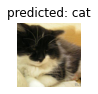

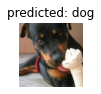

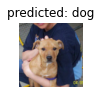

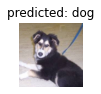

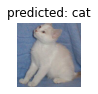

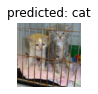

In [12]:
visualize_model(vgg16_ft)